## Importing the required libraries

In [12]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

In [13]:
from keras import regularizers

In [14]:
import os

In [15]:
mylist= os.listdir('/home/kanika/Documents/Major/Speech-Emotion-Analyzer-master/Data')

In [16]:
type(mylist)

list

In [17]:
print(mylist[1400])
print(len(mylist))

03-01-07-01-02-02-20.wav
1440


In [18]:
print(mylist[400][6:-16])

02


## Plotting the audio file's waveform and its spectrogram

In [8]:
data, sampling_rate = librosa.load('RawData/f11 (2).wav')

In [26]:
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

NameError: name 'data' is not defined

<Figure size 1080x360 with 0 Axes>

In [27]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
import sys


sr,x = scipy.io.wavfile.read('RawData/f10 (2).wav')

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'RawData/f10 (2).wav'

## Setting the labels

In [28]:
feeling_list=[]
for item in mylist:
    if item[6:-16]=='02' and int(item[18:-4])%2==0:
        feeling_list.append('female_calm')
    elif item[6:-16]=='02' and int(item[18:-4])%2==1:
        feeling_list.append('male_calm')
    elif item[6:-16]=='03' and int(item[18:-4])%2==0:
        feeling_list.append('female_happy')
    elif item[6:-16]=='03' and int(item[18:-4])%2==1:
        feeling_list.append('male_happy')
    elif item[6:-16]=='04' and int(item[18:-4])%2==0:
        feeling_list.append('female_sad')
    elif item[6:-16]=='04' and int(item[18:-4])%2==1:
        feeling_list.append('male_sad')
    elif item[6:-16]=='05' and int(item[18:-4])%2==0:
        feeling_list.append('female_angry')
    elif item[6:-16]=='05' and int(item[18:-4])%2==1:
        feeling_list.append('male_angry')
    elif item[6:-16]=='06' and int(item[18:-4])%2==0:
        feeling_list.append('female_fearful')
    elif item[6:-16]=='06' and int(item[18:-4])%2==1:
        feeling_list.append('male_fearful')
    elif item[:1]=='a':
        feeling_list.append('male_angry')
    elif item[:1]=='f':
        feeling_list.append('male_fearful')
    elif item[:1]=='h':
        feeling_list.append('male_happy')
    #elif item[:1]=='n':
        #feeling_list.append('neutral')
    elif item[:2]=='sa':
        feeling_list.append('male_sad')

In [29]:
labels = pd.DataFrame(feeling_list)

In [30]:
labels[:10]

,0
0,male_fearful
1,female_calm
2,female_sad
3,female_sad
4,female_fearful
5,female_happy
6,male_calm
7,male_fearful
8,male_angry
9,female_calm


## Getting the features of audio files using librosa

In [32]:
df = pd.DataFrame(columns=['feature'])
bookmark=0
for index,y in enumerate(mylist):
    if mylist[index][6:-16]!='01' and mylist[index][6:-16]!='07' and mylist[index][6:-16]!='08' and mylist[index][:2]!='su' and mylist[index][:1]!='n' and mylist[index][:1]!='d':
        X, sample_rate = librosa.load('/home/kanika/Documents/Major/Speech-Emotion-Analyzer-master/Data/'+y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                            sr=sample_rate, 
                                            n_mfcc=13),
                        axis=0)
        feature = mfccs
        #[float(i) for i in feature]
        #feature1=feature[:135]
        df.loc[bookmark] = [feature]
        bookmark=bookmark+1        

In [33]:
df[:5]

,feature
0,"[-57.32151, -57.83526, -61.016624, -62.746513,..."
1,"[-68.50275, -68.50275, -68.50275, -68.50275, -..."
2,"[-66.8854, -66.8854, -66.8854, -66.8854, -66.8..."
3,"[-54.660435, -54.80113, -54.17485, -56.207012,..."
4,"[-55.21731, -57.142357, -56.97951, -56.66498, ..."


In [34]:
df3 = pd.DataFrame(df['feature'].values.tolist())

df3[:5]

In [35]:
newdf = pd.concat([df3,labels], axis=1)

In [36]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})

In [37]:
rnewdf[:5]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
0,-57.321510,-57.835258,-61.016624,-62.746513,-58.665215,-60.775200,-61.271671,-56.750999,-56.353233,-56.273521,...,-50.658981,-50.314735,-51.468235,-53.492142,-53.449692,-55.136826,-56.441799,-53.876381,-53.726170,male_fearful
1,-68.502747,-68.502747,-68.502747,-68.502747,-68.502747,-68.502747,-68.502747,-68.502747,-68.502747,-68.502747,...,-59.474018,-63.432533,-64.038330,-58.799248,-57.890312,-62.155491,-68.502747,-68.336723,-68.385658,female_calm
2,-66.885399,-66.885399,-66.885399,-66.885399,-66.885399,-66.885399,-66.885399,-66.885399,-66.885399,-66.885399,...,-64.676285,-59.603863,-58.689316,-61.263062,-62.019516,-65.621262,-63.282192,-57.725925,-56.445858,female_sad
3,-54.660435,-54.801128,-54.174850,-56.207012,-52.512180,-53.809551,-54.603172,-55.583664,-54.093208,-53.048031,...,-52.305706,-54.098843,-55.128151,-60.419147,-55.361618,-53.379673,-55.778790,-61.106613,-61.522129,female_sad
4,-55.217312,-57.142357,-56.979511,-56.664982,-57.439548,-57.614170,-57.124355,-56.951164,-56.631126,-56.283089,...,-53.750137,-56.681755,-56.086063,-57.121132,-57.198044,-57.852798,-57.664429,-55.603500,-54.206291,female_fearful


In [38]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)
rnewdf[:10]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
652,-59.285912,-58.662746,-56.796532,-54.890263,-54.424412,-56.386520,-57.998100,-58.918205,-58.526035,-57.639275,...,-65.915726,-66.017220,-65.916924,-62.567467,-62.344139,-65.501350,-63.570717,-59.970089,-56.799137,male_sad
264,-42.612179,-44.166237,-46.185032,-44.702591,-42.975319,-44.313457,-44.428078,-44.274414,-43.780632,-43.182186,...,-39.133877,-39.412006,-37.711998,-39.044552,-38.289967,-38.845623,-40.895973,-42.518826,-43.199871,male_happy
271,-37.781998,-37.955757,-41.867718,-43.668159,-43.195824,-43.210384,-44.112366,-45.227882,-45.010986,-44.672104,...,-48.587936,-48.670307,-48.672791,-47.655327,-47.582119,-48.289742,-48.056358,-48.014286,-48.463039,male_fearful
695,-65.191589,-65.191589,-65.191589,-65.191589,-65.191589,-65.191589,-65.191589,-65.191589,-65.191589,-65.191589,...,-47.884926,-47.278912,-48.261562,-47.216820,-44.945267,-45.441326,-47.107605,-52.104263,-54.900394,female_calm
832,-63.898258,-59.659367,-56.782402,-54.998432,-58.540775,-63.898258,-61.179314,-58.758705,-61.959270,-63.536812,...,-56.474083,-58.214912,-58.713482,-58.827713,-57.919724,-57.178623,-57.815914,-62.274441,-63.898258,male_fearful
519,-45.871578,-45.871578,-45.871578,-45.871578,-45.871578,-45.871578,-45.871578,-45.871578,-45.871578,-45.871578,...,-34.769211,-35.539146,-38.184052,-36.689140,-35.603161,-35.669231,-35.926704,-35.287487,-34.311398,female_angry
794,-49.196129,-48.044453,-48.758469,-50.079197,-50.079197,-50.079197,-49.985477,-50.062176,-50.079197,-50.079197,...,-21.324013,-21.457090,-22.004885,-23.449120,-23.008583,-24.557259,-24.817484,-23.378620,-21.804491,male_angry
786,-61.080891,-61.470585,-61.351925,-59.571072,-59.312107,-59.351807,-62.197510,-61.885139,-59.451599,-61.568367,...,-44.797737,-44.210587,-44.046528,-44.359676,-46.438553,-48.639870,-46.470398,-47.464104,-49.256027,male_calm
549,-42.496696,-40.683514,-39.928291,-40.250160,-40.637547,-40.223694,-40.783562,-40.889061,-40.087566,-40.934109,...,-41.472267,-40.679695,-39.669472,-40.037292,-40.351273,-41.536926,-41.766766,-40.129128,-39.644192,female_fearful
574,-58.422295,-58.422295,-58.535202,-58.431622,-57.747078,-57.535259,-58.422295,-58.398277,-58.344955,-58.380268,...,-46.481236,-45.848122,-48.013786,-46.745735,-46.297077,-48.637226,-49.142132,-47.933002,-48.412838,male_fearful


In [39]:
rnewdf=rnewdf.fillna(0)

## Dividing the data into test and train

In [40]:
newdf1 = np.random.rand(len(rnewdf)) < 0.8
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [41]:
train[250:260]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
689,-50.638081,-48.228836,-48.415012,-48.113029,-48.173935,-47.791752,-46.218651,-45.054356,-45.362675,-45.369656,...,-26.810787,-26.735493,-28.539263,-31.688261,-31.474255,-31.985975,-32.624325,-35.602612,-36.271744,male_happy
746,-63.131760,-61.888165,-59.611080,-57.938660,-61.089241,-60.685398,-62.597221,-68.623734,-69.007225,-66.853775,...,-63.206009,-60.798752,-60.709072,-56.783302,-55.975403,-61.550987,-63.805744,-60.823490,-57.963688,male_calm
815,-57.737450,-59.686131,-57.828850,-55.253662,-56.984299,-56.965782,-57.298374,-57.570457,-57.718994,-58.874512,...,-51.479553,-53.759270,-54.388596,-55.250530,-54.296021,-53.732388,-55.841160,-57.228989,-60.722336,female_sad
115,-65.707649,-65.707649,-63.114719,-61.518997,-61.097134,-63.424595,-63.720058,-56.854614,-55.168972,-54.640007,...,-39.792141,-40.613159,-41.209206,-41.439194,-43.994286,-49.399620,-50.591599,-49.144062,-48.705647,female_calm
807,-63.790466,-63.947456,-63.355610,-63.286240,-63.246239,-62.802952,-62.743813,-62.665565,-62.665565,-62.665565,...,-53.914062,-52.145931,-52.200073,-52.263309,-53.177227,-53.587490,-54.778591,-55.114746,-54.505997,female_sad
637,-52.000729,-52.000729,-52.000729,-51.157795,-51.038548,-51.565109,-52.000729,-52.000729,-51.692673,-51.630722,...,-45.041477,-46.360538,-47.435749,-45.051735,-45.605301,-45.434124,-45.584862,-44.438187,-43.538654,male_happy
728,-54.475822,-54.475822,-54.475822,-54.475822,-54.475822,-54.475822,-54.475822,-54.475822,-54.475822,-54.475822,...,-53.762047,-52.983219,-54.475822,-54.475822,-54.475822,-54.475822,-54.475822,-54.475822,-54.475822,female_fearful
680,-52.543320,-52.900917,-50.362530,-46.141300,-48.566555,-50.858135,-52.272621,-49.521519,-47.651199,-45.625748,...,-47.986832,-49.680180,-52.731979,-51.756145,-51.770199,-53.004887,-53.497555,-53.787411,-52.571815,female_happy
388,-63.509113,-63.633812,-63.504398,-63.299423,-63.838970,-65.177299,-66.479500,-65.160202,-65.833740,-64.724396,...,-40.389946,-36.990444,-38.102470,-40.782669,-40.174320,-40.962994,-43.929958,-43.562027,-41.383232,male_calm
722,-59.806988,-61.757298,-66.645981,-65.127586,-62.448807,-61.828403,-62.077156,-66.091736,-66.174927,-59.648991,...,-42.003273,-43.790825,-38.334808,-31.672123,-30.431236,-28.434568,-26.703886,-26.550127,-24.701975,male_sad


In [42]:
trainfeatures = train.iloc[:, :-1]

In [43]:
trainlabel = train.iloc[:, -1:]

In [44]:
testfeatures = test.iloc[:, :-1]

In [45]:
testlabel = test.iloc[:, -1:]

In [46]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))


/home/kanika/anaconda3/envs/minor/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [47]:
y_train

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [48]:
X_train.shape

(773, 216)

## Changing dimension for CNN model

In [49]:

x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [50]:
model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(216,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)

Instructions for updating:
Colocations handled automatically by placer.


In [51]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 216, 256)          1536      
_________________________________________________________________
activation_1 (Activation)    (None, 216, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 216, 128)          163968    
_________________________________________________________________
activation_2 (Activation)    (None, 216, 128)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 216, 128)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 27, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 27, 128)          

In [52]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

### Removed the whole training part for avoiding unnecessary long epochs list

In [53]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=700, validation_data=(x_testcnn, y_test))

Instructions for updating:
Use tf.cast instead.
Train on 773 samples, validate on 187 samples
Epoch 1/700
773/773 [==============================] - 6s 8ms/step - loss: 2.4006 - accuracy: 0.1087 - val_loss: 2.2705 - val_accuracy: 0.1337
Epoch 2/700
773/773 [==============================] - 6s 8ms/step - loss: 2.2517 - accuracy: 0.1591 - val_loss: 2.2449 - val_accuracy: 0.2139
Epoch 3/700
773/773 [==============================] - 6s 8ms/step - loss: 2.2070 - accuracy: 0.1928 - val_loss: 2.2428 - val_accuracy: 0.1390
Epoch 4/700
773/773 [==============================] - 6s 8ms/step - loss: 2.1916 - accuracy: 0.2122 - val_loss: 2.1993 - val_accuracy: 0.2139
Epoch 5/700
773/773 [==============================] - 6s 8ms/step - loss: 2.1662 - accuracy: 0.2147 - val_loss: 2.1924 - val_accuracy: 0.1979
Epoch 6/700
773/773 [==============================] - 6s 8ms/step - loss: 2.1480 - accuracy: 0.2380 - val_loss: 2.1653 - val_accuracy: 0.2086
Epoch 7/700
773/773 [===========================

Epoch 56/700
773/773 [==============================] - 6s 8ms/step - loss: 1.5791 - accuracy: 0.4347 - val_loss: 1.7380 - val_accuracy: 0.3583
Epoch 57/700
773/773 [==============================] - 6s 8ms/step - loss: 1.5684 - accuracy: 0.4373 - val_loss: 1.7452 - val_accuracy: 0.3316
Epoch 58/700
773/773 [==============================] - 6s 8ms/step - loss: 1.5648 - accuracy: 0.4541 - val_loss: 1.7366 - val_accuracy: 0.3155
Epoch 59/700
773/773 [==============================] - 6s 8ms/step - loss: 1.5529 - accuracy: 0.4476 - val_loss: 1.7486 - val_accuracy: 0.3422
Epoch 60/700
773/773 [==============================] - 6s 8ms/step - loss: 1.5451 - accuracy: 0.4554 - val_loss: 1.7231 - val_accuracy: 0.3690
Epoch 61/700
773/773 [==============================] - 6s 8ms/step - loss: 1.5477 - accuracy: 0.4360 - val_loss: 1.7129 - val_accuracy: 0.3422
Epoch 62/700
773/773 [==============================] - 6s 8ms/step - loss: 1.5263 - accuracy: 0.4567 - val_loss: 1.7172 - val_accuracy:

Epoch 113/700
773/773 [==============================] - 6s 8ms/step - loss: 1.2695 - accuracy: 0.5252 - val_loss: 1.5264 - val_accuracy: 0.3850
Epoch 114/700
773/773 [==============================] - 6s 8ms/step - loss: 1.2697 - accuracy: 0.5278 - val_loss: 1.6057 - val_accuracy: 0.3743
Epoch 115/700
773/773 [==============================] - 6s 8ms/step - loss: 1.2650 - accuracy: 0.5420 - val_loss: 1.5505 - val_accuracy: 0.4118
Epoch 116/700
773/773 [==============================] - 6s 8ms/step - loss: 1.2634 - accuracy: 0.5330 - val_loss: 1.5945 - val_accuracy: 0.3529
Epoch 117/700
773/773 [==============================] - 6s 8ms/step - loss: 1.2641 - accuracy: 0.5433 - val_loss: 1.5354 - val_accuracy: 0.4064
Epoch 118/700
773/773 [==============================] - 6s 8ms/step - loss: 1.2581 - accuracy: 0.5408 - val_loss: 1.5462 - val_accuracy: 0.4064
Epoch 119/700
773/773 [==============================] - 6s 8ms/step - loss: 1.2529 - accuracy: 0.5524 - val_loss: 1.5733 - val_ac

773/773 [==============================] - 6s 8ms/step - loss: 1.1265 - accuracy: 0.6210 - val_loss: 1.5781 - val_accuracy: 0.3850
Epoch 170/700
773/773 [==============================] - 6s 8ms/step - loss: 1.1259 - accuracy: 0.5821 - val_loss: 1.5004 - val_accuracy: 0.4492
Epoch 171/700
773/773 [==============================] - 6s 8ms/step - loss: 1.1268 - accuracy: 0.6016 - val_loss: 1.5069 - val_accuracy: 0.4225
Epoch 172/700
773/773 [==============================] - 6s 8ms/step - loss: 1.1098 - accuracy: 0.6067 - val_loss: 1.5544 - val_accuracy: 0.3636
Epoch 173/700
773/773 [==============================] - 6s 8ms/step - loss: 1.1157 - accuracy: 0.5938 - val_loss: 1.5303 - val_accuracy: 0.4492
Epoch 174/700
773/773 [==============================] - 6s 8ms/step - loss: 1.1094 - accuracy: 0.5964 - val_loss: 1.4914 - val_accuracy: 0.3957
Epoch 175/700
773/773 [==============================] - 6s 8ms/step - loss: 1.1058 - accuracy: 0.6003 - val_loss: 1.5218 - val_accuracy: 0.3904

773/773 [==============================] - 7s 9ms/step - loss: 1.0122 - accuracy: 0.6261 - val_loss: 1.4868 - val_accuracy: 0.4385
Epoch 226/700
773/773 [==============================] - 9s 11ms/step - loss: 0.9965 - accuracy: 0.6287 - val_loss: 1.4687 - val_accuracy: 0.4439
Epoch 227/700
773/773 [==============================] - 8s 10ms/step - loss: 1.0064 - accuracy: 0.6455 - val_loss: 1.4969 - val_accuracy: 0.4225
Epoch 228/700
773/773 [==============================] - 7s 9ms/step - loss: 1.0000 - accuracy: 0.6507 - val_loss: 1.4746 - val_accuracy: 0.4278
Epoch 229/700
773/773 [==============================] - 7s 9ms/step - loss: 0.9986 - accuracy: 0.6326 - val_loss: 1.5526 - val_accuracy: 0.3636
Epoch 230/700
773/773 [==============================] - 7s 9ms/step - loss: 1.0014 - accuracy: 0.6507 - val_loss: 1.5021 - val_accuracy: 0.4278
Epoch 231/700
773/773 [==============================] - 7s 9ms/step - loss: 0.9954 - accuracy: 0.6235 - val_loss: 1.5097 - val_accuracy: 0.41

773/773 [==============================] - 7s 9ms/step - loss: 0.9120 - accuracy: 0.6805 - val_loss: 1.5197 - val_accuracy: 0.4171
Epoch 282/700
773/773 [==============================] - 7s 9ms/step - loss: 0.9077 - accuracy: 0.6766 - val_loss: 1.5129 - val_accuracy: 0.3957
Epoch 283/700
773/773 [==============================] - 7s 9ms/step - loss: 0.9055 - accuracy: 0.6831 - val_loss: 1.4986 - val_accuracy: 0.4332
Epoch 284/700
773/773 [==============================] - 7s 9ms/step - loss: 0.9030 - accuracy: 0.6753 - val_loss: 1.5498 - val_accuracy: 0.4332
Epoch 285/700
773/773 [==============================] - 7s 9ms/step - loss: 0.8928 - accuracy: 0.6934 - val_loss: 1.5329 - val_accuracy: 0.4545
Epoch 286/700
773/773 [==============================] - 58s 75ms/step - loss: 0.8974 - accuracy: 0.6921 - val_loss: 1.5275 - val_accuracy: 0.3904
Epoch 287/700
773/773 [==============================] - 6s 8ms/step - loss: 0.8914 - accuracy: 0.6947 - val_loss: 1.4939 - val_accuracy: 0.44

773/773 [==============================] - 6s 7ms/step - loss: 0.8077 - accuracy: 0.7141 - val_loss: 1.5360 - val_accuracy: 0.4492
Epoch 338/700
773/773 [==============================] - 8s 10ms/step - loss: 0.8015 - accuracy: 0.7348 - val_loss: 1.5450 - val_accuracy: 0.4599
Epoch 339/700
773/773 [==============================] - 10s 13ms/step - loss: 0.7973 - accuracy: 0.7374 - val_loss: 1.5635 - val_accuracy: 0.3850
Epoch 340/700
773/773 [==============================] - 10s 12ms/step - loss: 0.7998 - accuracy: 0.7309 - val_loss: 1.5170 - val_accuracy: 0.4439
Epoch 341/700
773/773 [==============================] - 6s 8ms/step - loss: 0.8013 - accuracy: 0.7128 - val_loss: 1.5573 - val_accuracy: 0.4118
Epoch 342/700
773/773 [==============================] - 6s 7ms/step - loss: 0.7957 - accuracy: 0.7089 - val_loss: 1.6271 - val_accuracy: 0.3743
Epoch 343/700
773/773 [==============================] - 6s 7ms/step - loss: 0.7948 - accuracy: 0.7361 - val_loss: 1.5407 - val_accuracy: 0

773/773 [==============================] - 6s 8ms/step - loss: 0.7039 - accuracy: 0.7736 - val_loss: 1.6057 - val_accuracy: 0.4011
Epoch 394/700
773/773 [==============================] - 6s 8ms/step - loss: 0.7059 - accuracy: 0.7646 - val_loss: 1.5710 - val_accuracy: 0.4439
Epoch 395/700
773/773 [==============================] - 6s 8ms/step - loss: 0.6905 - accuracy: 0.7646 - val_loss: 1.5641 - val_accuracy: 0.4118
Epoch 396/700
773/773 [==============================] - 6s 8ms/step - loss: 0.6974 - accuracy: 0.7646 - val_loss: 1.5883 - val_accuracy: 0.4385
Epoch 397/700
773/773 [==============================] - 6s 8ms/step - loss: 0.6930 - accuracy: 0.7697 - val_loss: 1.5806 - val_accuracy: 0.4171
Epoch 398/700
773/773 [==============================] - 6s 8ms/step - loss: 0.6826 - accuracy: 0.7749 - val_loss: 1.5709 - val_accuracy: 0.4545
Epoch 399/700
773/773 [==============================] - 6s 8ms/step - loss: 0.6969 - accuracy: 0.7723 - val_loss: 1.5999 - val_accuracy: 0.4332

773/773 [==============================] - 6s 8ms/step - loss: 0.6086 - accuracy: 0.7982 - val_loss: 1.6724 - val_accuracy: 0.3850
Epoch 450/700
773/773 [==============================] - 6s 8ms/step - loss: 0.5971 - accuracy: 0.8137 - val_loss: 1.6847 - val_accuracy: 0.4118
Epoch 451/700
773/773 [==============================] - 6s 8ms/step - loss: 0.5974 - accuracy: 0.8047 - val_loss: 1.6659 - val_accuracy: 0.3850
Epoch 452/700
773/773 [==============================] - 6s 8ms/step - loss: 0.5986 - accuracy: 0.8150 - val_loss: 1.6232 - val_accuracy: 0.4278
Epoch 453/700
773/773 [==============================] - 6s 8ms/step - loss: 0.5978 - accuracy: 0.8047 - val_loss: 1.6409 - val_accuracy: 0.4171
Epoch 454/700
773/773 [==============================] - 6s 8ms/step - loss: 0.5937 - accuracy: 0.8034 - val_loss: 1.6664 - val_accuracy: 0.4171
Epoch 455/700
773/773 [==============================] - 6s 8ms/step - loss: 0.5904 - accuracy: 0.8163 - val_loss: 1.6514 - val_accuracy: 0.4332

773/773 [==============================] - 6s 8ms/step - loss: 0.5065 - accuracy: 0.8525 - val_loss: 1.6846 - val_accuracy: 0.4011
Epoch 506/700
773/773 [==============================] - 6s 8ms/step - loss: 0.4977 - accuracy: 0.8525 - val_loss: 1.6902 - val_accuracy: 0.4064
Epoch 507/700
773/773 [==============================] - 6s 8ms/step - loss: 0.4985 - accuracy: 0.8590 - val_loss: 1.7102 - val_accuracy: 0.4278
Epoch 508/700
773/773 [==============================] - 6s 8ms/step - loss: 0.4917 - accuracy: 0.8473 - val_loss: 1.7302 - val_accuracy: 0.4011
Epoch 509/700
773/773 [==============================] - 6s 8ms/step - loss: 0.4870 - accuracy: 0.8499 - val_loss: 1.7094 - val_accuracy: 0.3957
Epoch 510/700
773/773 [==============================] - 6s 8ms/step - loss: 0.5000 - accuracy: 0.8461 - val_loss: 1.7160 - val_accuracy: 0.3957
Epoch 511/700
773/773 [==============================] - 6s 8ms/step - loss: 0.4869 - accuracy: 0.8525 - val_loss: 1.7601 - val_accuracy: 0.4064

773/773 [==============================] - 6s 8ms/step - loss: 0.4075 - accuracy: 0.8887 - val_loss: 1.8288 - val_accuracy: 0.4118
Epoch 562/700
773/773 [==============================] - 6s 8ms/step - loss: 0.4039 - accuracy: 0.8926 - val_loss: 1.8058 - val_accuracy: 0.4118
Epoch 563/700
773/773 [==============================] - 6s 8ms/step - loss: 0.3956 - accuracy: 0.8913 - val_loss: 1.8079 - val_accuracy: 0.4118
Epoch 564/700
773/773 [==============================] - 6s 8ms/step - loss: 0.4079 - accuracy: 0.8823 - val_loss: 1.8152 - val_accuracy: 0.3957
Epoch 565/700
773/773 [==============================] - 6s 8ms/step - loss: 0.3966 - accuracy: 0.8849 - val_loss: 1.8038 - val_accuracy: 0.4225
Epoch 566/700
773/773 [==============================] - 6s 8ms/step - loss: 0.3981 - accuracy: 0.8823 - val_loss: 1.8100 - val_accuracy: 0.4118
Epoch 567/700
773/773 [==============================] - 6s 8ms/step - loss: 0.3928 - accuracy: 0.8991 - val_loss: 1.8144 - val_accuracy: 0.4064

773/773 [==============================] - 6s 8ms/step - loss: 0.3126 - accuracy: 0.9198 - val_loss: 1.9412 - val_accuracy: 0.4011
Epoch 618/700
773/773 [==============================] - 6s 8ms/step - loss: 0.3093 - accuracy: 0.9301 - val_loss: 1.9629 - val_accuracy: 0.4064
Epoch 619/700
773/773 [==============================] - 6s 8ms/step - loss: 0.3020 - accuracy: 0.9314 - val_loss: 1.9152 - val_accuracy: 0.3904
Epoch 620/700
773/773 [==============================] - 6s 8ms/step - loss: 0.3104 - accuracy: 0.9224 - val_loss: 1.9392 - val_accuracy: 0.3957
Epoch 621/700
773/773 [==============================] - 6s 8ms/step - loss: 0.2975 - accuracy: 0.9288 - val_loss: 1.9674 - val_accuracy: 0.3957
Epoch 622/700
773/773 [==============================] - 6s 8ms/step - loss: 0.2977 - accuracy: 0.9301 - val_loss: 1.9771 - val_accuracy: 0.4011
Epoch 623/700
773/773 [==============================] - 6s 8ms/step - loss: 0.3027 - accuracy: 0.9288 - val_loss: 1.9543 - val_accuracy: 0.3904

773/773 [==============================] - 6s 8ms/step - loss: 0.2236 - accuracy: 0.9483 - val_loss: 2.1217 - val_accuracy: 0.3850
Epoch 674/700
773/773 [==============================] - 6s 8ms/step - loss: 0.2278 - accuracy: 0.9521 - val_loss: 2.0559 - val_accuracy: 0.4064
Epoch 675/700
773/773 [==============================] - 6s 8ms/step - loss: 0.2200 - accuracy: 0.9651 - val_loss: 2.0569 - val_accuracy: 0.4385
Epoch 676/700
773/773 [==============================] - 6s 8ms/step - loss: 0.2128 - accuracy: 0.9599 - val_loss: 2.1389 - val_accuracy: 0.4118
Epoch 677/700
773/773 [==============================] - 6s 8ms/step - loss: 0.2213 - accuracy: 0.9599 - val_loss: 2.0941 - val_accuracy: 0.4011
Epoch 678/700
773/773 [==============================] - 6s 8ms/step - loss: 0.2157 - accuracy: 0.9586 - val_loss: 2.0625 - val_accuracy: 0.4011
Epoch 679/700
773/773 [==============================] - 6s 8ms/step - loss: 0.2179 - accuracy: 0.9599 - val_loss: 2.1117 - val_accuracy: 0.4171

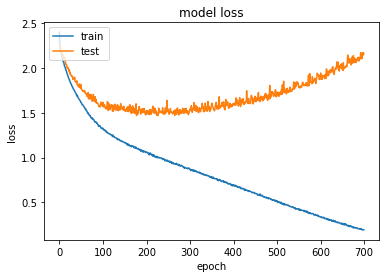

In [54]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Saving the model

In [55]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /home/kanika/Documents/Major/Speech-Emotion-Analyzer-master/saved_models/Emotion_Voice_Detection_Model.h5 


In [56]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

## Loading the model

In [57]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Voice_Detection_Model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 39.04%


## Predicting emotions on the test data

In [58]:
preds = loaded_model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

187/187 [==============================] - 1s 3ms/step


In [59]:
preds

array([[5.47428250e-01, 8.22195085e-04, 1.27552636e-03, ...,
        2.75677573e-02, 8.34079832e-03, 3.09424549e-02],
       [4.91349567e-07, 1.41759005e-08, 1.77573733e-09, ...,
        5.94491400e-02, 9.21339452e-01, 9.70969349e-03],
       [1.62194192e-03, 2.07708672e-01, 1.91121753e-02, ...,
        2.95180289e-05, 3.43761858e-05, 4.09425265e-04],
       ...,
       [4.02465686e-02, 4.06211824e-04, 1.00519945e-04, ...,
        2.23190864e-06, 4.81571669e-06, 3.43493884e-04],
       [1.20741269e-03, 2.52288004e-07, 4.09397110e-02, ...,
        1.03456026e-04, 9.70715992e-05, 1.26551577e-05],
       [1.17035307e-01, 2.80207163e-03, 1.34259768e-04, ...,
        5.63142121e-01, 1.67606980e-01, 1.55618764e-04]], dtype=float32)

In [60]:
preds1=preds.argmax(axis=1)

In [61]:
preds1

array([0, 8, 4, 6, 1, 5, 7, 3, 2, 1, 4, 2, 7, 4, 2, 7, 6, 4, 5, 2, 8, 9,
       1, 7, 1, 4, 7, 5, 3, 2, 7, 5, 7, 3, 9, 6, 7, 4, 2, 0, 1, 1, 9, 6,
       4, 5, 0, 3, 0, 9, 0, 0, 1, 3, 6, 1, 8, 6, 6, 8, 1, 0, 1, 1, 6, 0,
       9, 0, 0, 9, 0, 6, 4, 1, 1, 8, 4, 5, 1, 2, 7, 8, 3, 3, 2, 2, 5, 7,
       6, 1, 6, 1, 6, 5, 5, 8, 2, 8, 3, 0, 9, 8, 7, 3, 8, 0, 3, 1, 4, 9,
       8, 1, 1, 5, 6, 4, 7, 9, 8, 6, 5, 1, 7, 0, 9, 6, 4, 2, 6, 6, 6, 6,
       0, 3, 3, 1, 6, 4, 9, 4, 1, 6, 3, 5, 2, 8, 7, 6, 1, 2, 8, 9, 7, 8,
       9, 0, 6, 9, 6, 7, 5, 9, 6, 8, 1, 1, 9, 8, 1, 6, 4, 5, 7, 6, 9, 5,
       4, 8, 8, 0, 4, 0, 0, 7, 4, 3, 7])

In [62]:
abc = preds1.astype(int).flatten()

In [63]:
predictions = (lb.inverse_transform((abc)))

In [64]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,female_angry
1,male_happy
2,female_sad
3,male_calm
4,female_calm
5,male_angry
6,male_fearful
7,female_happy
8,female_fearful
9,female_calm


In [65]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [66]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,female_angry
1,male_happy
2,female_sad
3,male_calm
4,female_calm
5,male_angry
6,male_fearful
7,male_fearful
8,female_fearful
9,female_calm


In [67]:
finaldf = actualdf.join(preddf)

## Actual v/s Predicted emotions

In [68]:
finaldf[170:180]

,actualvalues,predictedvalues
170,female_angry,female_sad
171,male_fearful,male_angry
172,male_happy,male_fearful
173,male_calm,male_calm
174,male_happy,male_sad
175,female_angry,male_angry
176,female_fearful,female_sad
177,male_happy,male_happy
178,male_angry,male_happy
179,female_fearful,female_angry


In [69]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
female_angry,20
female_calm,20
female_fearful,16
female_happy,16
female_sad,12
male_angry,20
male_calm,18
male_fearful,23
male_happy,21


In [70]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,19
female_calm,26
female_fearful,13
female_happy,14
female_sad,18
male_angry,15
male_calm,27
male_fearful,19
male_happy,19


In [131]:
finaldf.to_csv('Predictions.csv', index=False)

## Live Demo

#### The file 'output10.wav' in the next cell is the file that was recorded live using the code in AudioRecoreder notebook found in the repository

In [485]:
data, sampling_rate = librosa.load('output10.wav')

Populating the interactive namespace from numpy and matplotlib


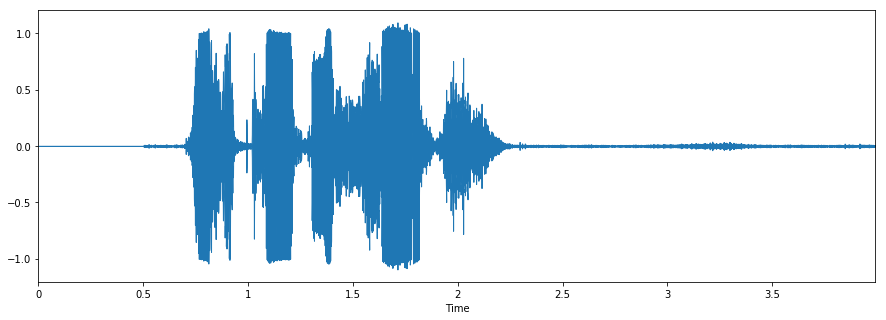

In [486]:
% pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

In [487]:
#livedf= pd.DataFrame(columns=['feature'])
X, sample_rate = librosa.load('output10.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
featurelive = mfccs
livedf2 = featurelive

In [488]:
livedf2= pd.DataFrame(data=livedf2)

In [489]:
livedf2 = livedf2.stack().to_frame().T

In [490]:
livedf2

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,-18.203564,-21.471836,-22.52221,-21.712259,-22.264288,-20.707904,-21.726444,-21.76865,-24.302736,-22.250634,...,-24.273819,-24.639939,-24.929152,-24.43919,-25.210171,-24.740646,-22.311913,-22.579805,-22.31466,-21.552436


In [491]:
twodim= np.expand_dims(livedf2, axis=2)

In [492]:
livepreds = loaded_model.predict(twodim, 
                         batch_size=32, 
                         verbose=1)

1/1 [==============================] - 0s


In [493]:
livepreds

array([[  9.24052530e-22,   0.00000000e+00,   3.62402176e-26,
          1.30680162e-36,   4.47264152e-28,   1.00000000e+00,
          1.80208343e-30,   2.76873961e-27,   3.62227194e-23,
          1.67396652e-11]], dtype=float32)

In [494]:
livepreds1=livepreds.argmax(axis=1)

In [495]:
liveabc = livepreds1.astype(int).flatten()

In [496]:
livepredictions = (lb.inverse_transform((liveabc)))
livepredictions

array(['male_angry'], dtype=object)